# mercury transit: making a composite image
On November 11, 2019, Mercury made a 5.5 hour transit across the Sun. In this notebook, we will be making a composite image of Mercury's transit across the Sun using data from both the NASA Solar Dynamics Observatory's Helioseismic and Magnetic Imager (HMI) instrument and the ESA Solar and Heliospheric Observatory's Michelson Doppler Imager (MDI) instrument.
### NASA Solar Dynamics Observatory's Helioseismic and Magnetic Imager (HMI) instrument

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, requests
import pandas as pd
from astropy.io import fits
from matplotlib.cm import register_cmap, cmap_d
from scipy import ndimage
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we define a color table exactly like the [SAO ds9 heat color table](http://nbviewer.jupyter.org/gist/adonath/c9a97d2f2d964ae7b9eb):

In [2]:
ds9heat = {'red': lambda v : np.interp(v, [0, 0.34, 1], [0, 1, 1]),
           'green': lambda v : np.interp(v, [0, 1], [0, 1]),
           'blue': lambda v : np.interp(v, [0, 0.65, 0.98, 1], [0, 0, 1, 1])}
register_cmap('ds9heat', data=ds9heat)

Then we'll grab the data. Normally we pull [continuum intensity data](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.Ic_720s) from the JSOC database, but these continuum intensity data were specially created from level-1 filtergram data such that the cadence of the images capture Mercury's ingress and egress. For the purpose of a composite image, using these data is a purely aesthetic choice, and the following methodology (with slightly different thresholds) works for the nominal continuum intensity data as well.

In [3]:
url = 'http://jsoc.stanford.edu/data/events/Mercury19_HMI_I/WholeSun/fits/'

In [4]:
files = pd.read_html(url)
list_of_files = files[0]['Name'][2:413]
print("There are",len(list_of_files),"files.")

There are 411 files.


The real difficulty in making a composite image is to capture the entire effect of Mercury as the scattered light around the planet creates a couple-pixel annulus with an intensity comparable to other regions of the Sun. To capture this effect, we follow a six-step procedure:

#### Step 1
After selecting all of the images that will go into our composite image (about every 20 minutes looks aesthetically pleasing), we subtract from each image a background image during which Mercury is not transiting the Sun. This differenced image (stored in variable `differenced_image`) is especially useful in eliminating the effect of limb darkening. We then set all pixels that are not within the transit path to zero.

#### Step 2
Then we apply a threshold to the differenced image to capture the pixels that correspond to Mercury. This requires some experiment: if we choose a threshold that is too high, we don't capture the entire planet. However, if we choose a threshold that is too low, we capture extraneous pixels. Therefore, we'll first apply a threshold that is too high -- to make sure we don't capture extraneous pixels -- and then generate a binary mask where the pixels labeled with a 1 represent the location of Mercury and the pixels labeled with a 0 represent the locations where Mercury does not exist (stored in variable `mask`). 

#### Step 3
Now, we'll compensate for the fact that we chose a low threshold: we'll use [morphological binary dilation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_dilation.html) to grow the radius of Mercury within the mask by a few pixels (stored in variable `dilated_mask`).

#### Step 4
We can create a masked image by multiplying this dilated binary mask by the original image to get the value of the pixels at the locations of Mercury (stored in variable `masked_image`).

In [5]:
background = fits.open("http://jsoc.stanford.edu/data/events/Mercury19_HMI_I/WholeSun/fits/20191111_123522_UTC.0001.fits")
background = background[1].data
mask_inverse = np.ones([4096,4096])
masked_image = np.zeros([4096,4096])
composite_dilated_mask = np.zeros([4096,4096])
for i in range(10,len(list_of_files),21):
    if (i == 409): 
        i = 406                                      # capture the egress
    mask = np.zeros([4096,4096])
    continuum = fits.open("http://jsoc.stanford.edu/data/events/Mercury19_HMI_I/WholeSun/fits/"+list_of_files[i])
    continuum = continuum[1].data
    differenced_image = background - continuum
    differenced_image[0:2000,:] = 0.0                # mask out the area outside the transit path
    differenced_image[2400:4096,:] = 0.0
    find_mercury = np.where(differenced_image > 11000)
    for i in range(len(find_mercury[0])):
        mask[find_mercury[0][i],find_mercury[1][i]] = 1.
    dilated_mask = ndimage.binary_dilation(mask, iterations=2).astype(mask.dtype)
    composite_dilated_mask = composite_dilated_mask + dilated_mask
    masked_image = continuum*dilated_mask + masked_image

This is what each of these arrays look like within the transit path:

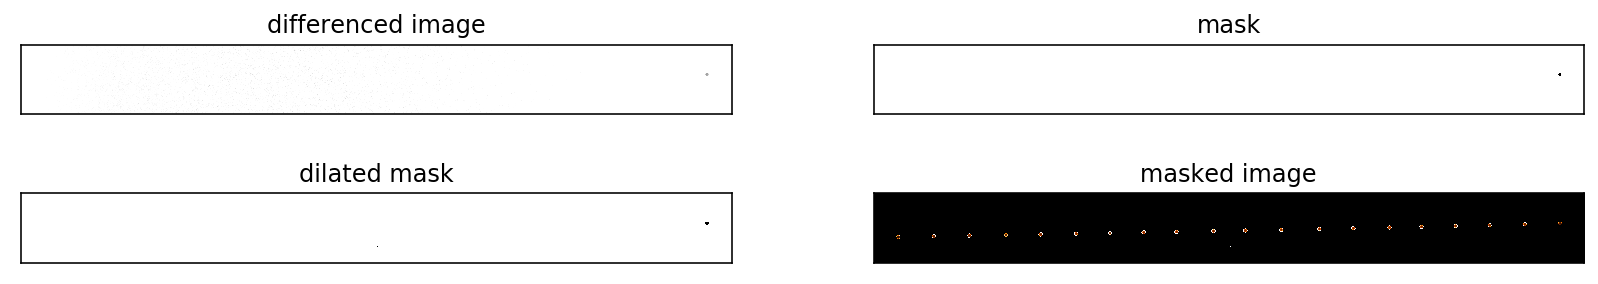

In [6]:
fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(2,2,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('differenced image')
plt.imshow(differenced_image[2000:2400,:],cmap='Greys',vmax=30000,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,2)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('mask')
plt.imshow(mask[2000:2400,:],cmap='Greys',vmax=1.,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,3)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('dilated mask')
plt.imshow(dilated_mask[2000:2400,:],cmap='Greys',vmax=1.,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,4)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('masked image')
plt.imshow(masked_image[2000:2400,:],cmap='ds9heat',vmax=20000,vmin=0,origin='lower')

#### Step 5
We can then multiply the inverse of the dilated binary mask -- where the the pixels labeled with a 0 represent the location of Mercury and the pixels labeled with a 1 represent the locations where Mercury does not exist (stored in variable `inverse_dilated_mask`) -- with the background image to create a composite image (stored in variable `composite`) with holes where Mercury should be.

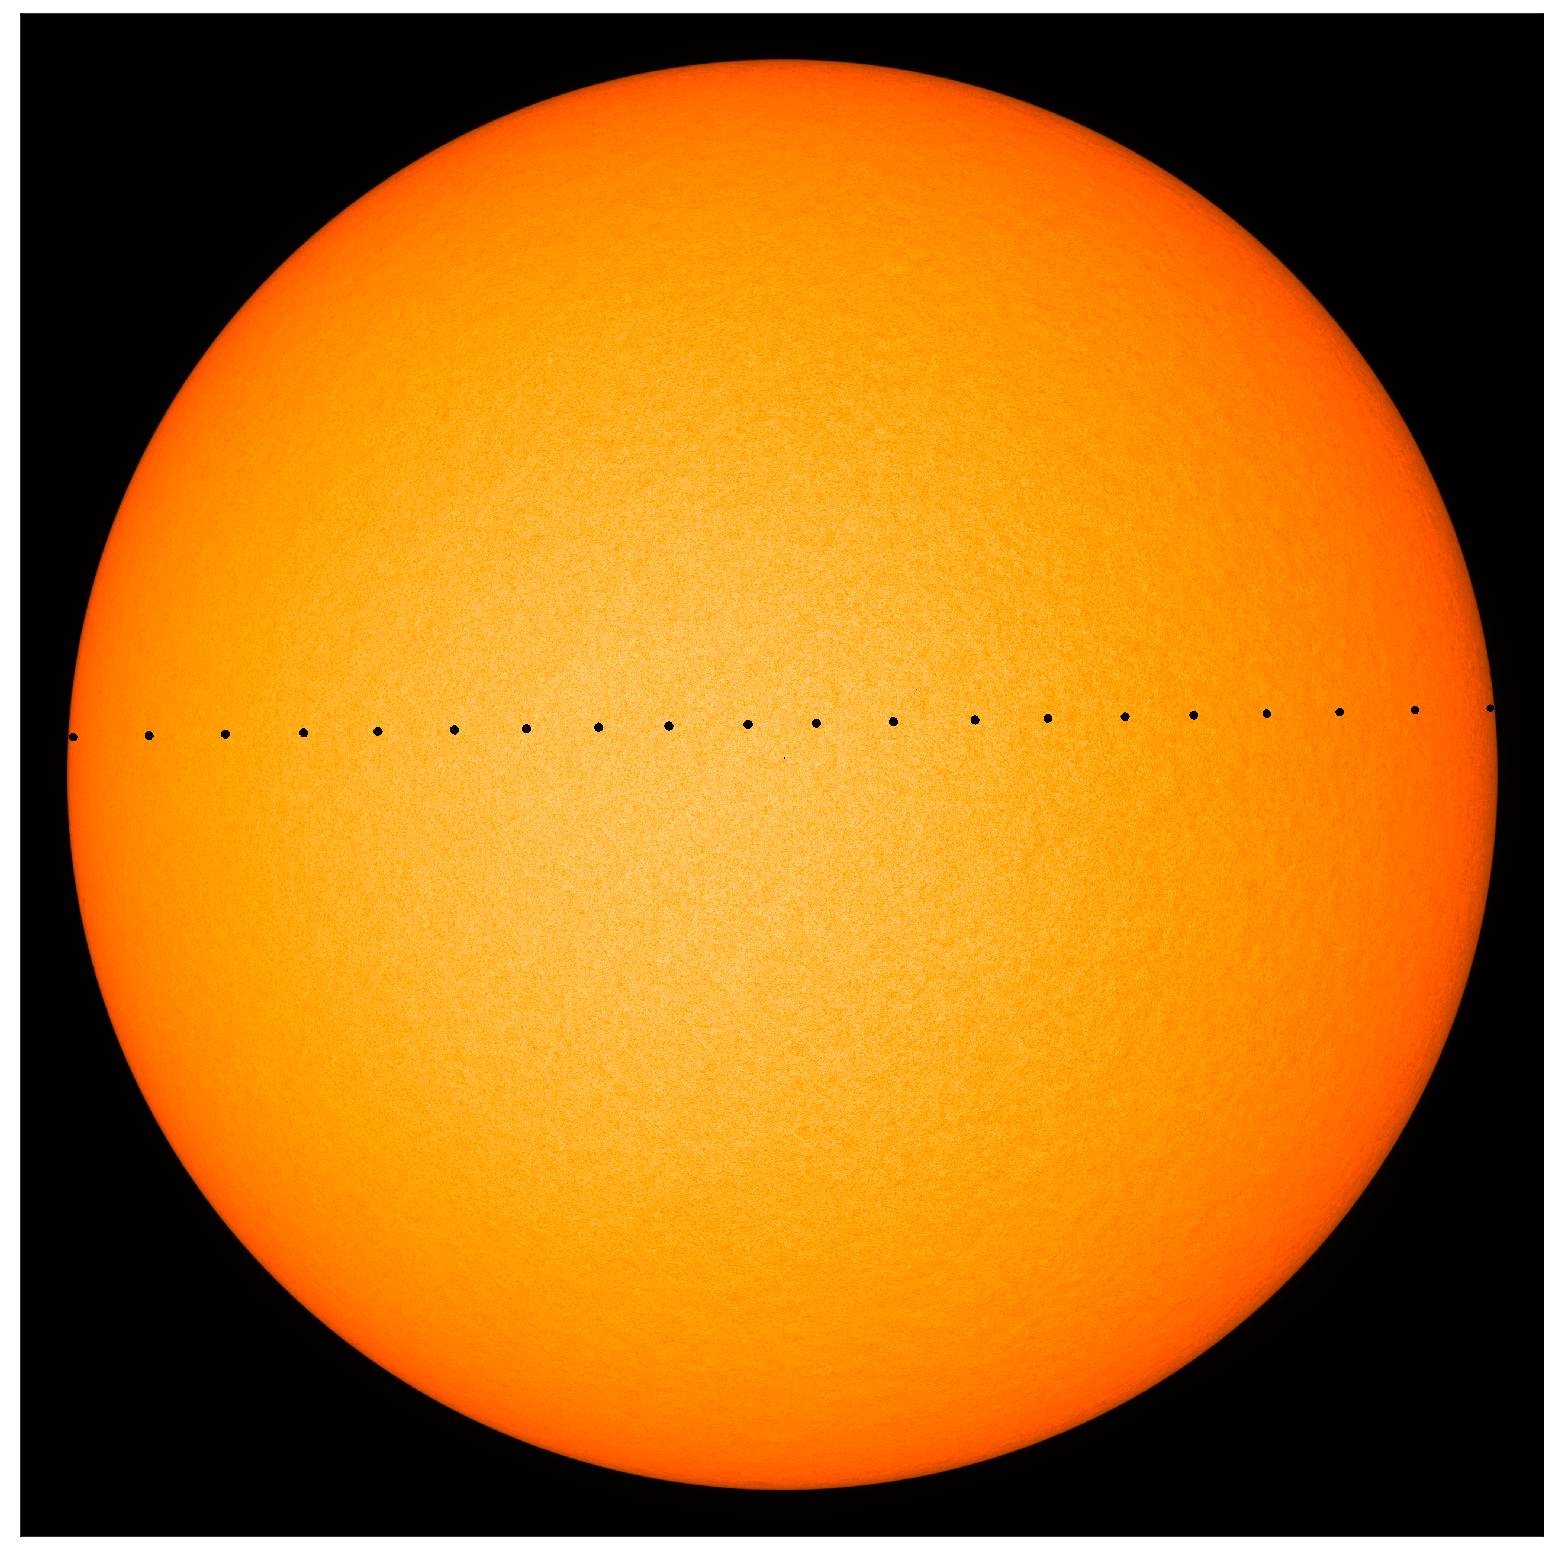

In [7]:
inverse_dilated_mask = np.logical_not(composite_dilated_mask).astype(composite_dilated_mask.dtype)
composite = background * inverse_dilated_mask
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(composite,cmap='ds9heat',vmax=62000,vmin=0,origin='lower')

#### Step 6
Finally, we can fill in these holes with the data by adding the composite image to the masked image.

The maximum value of this array is  961863.0


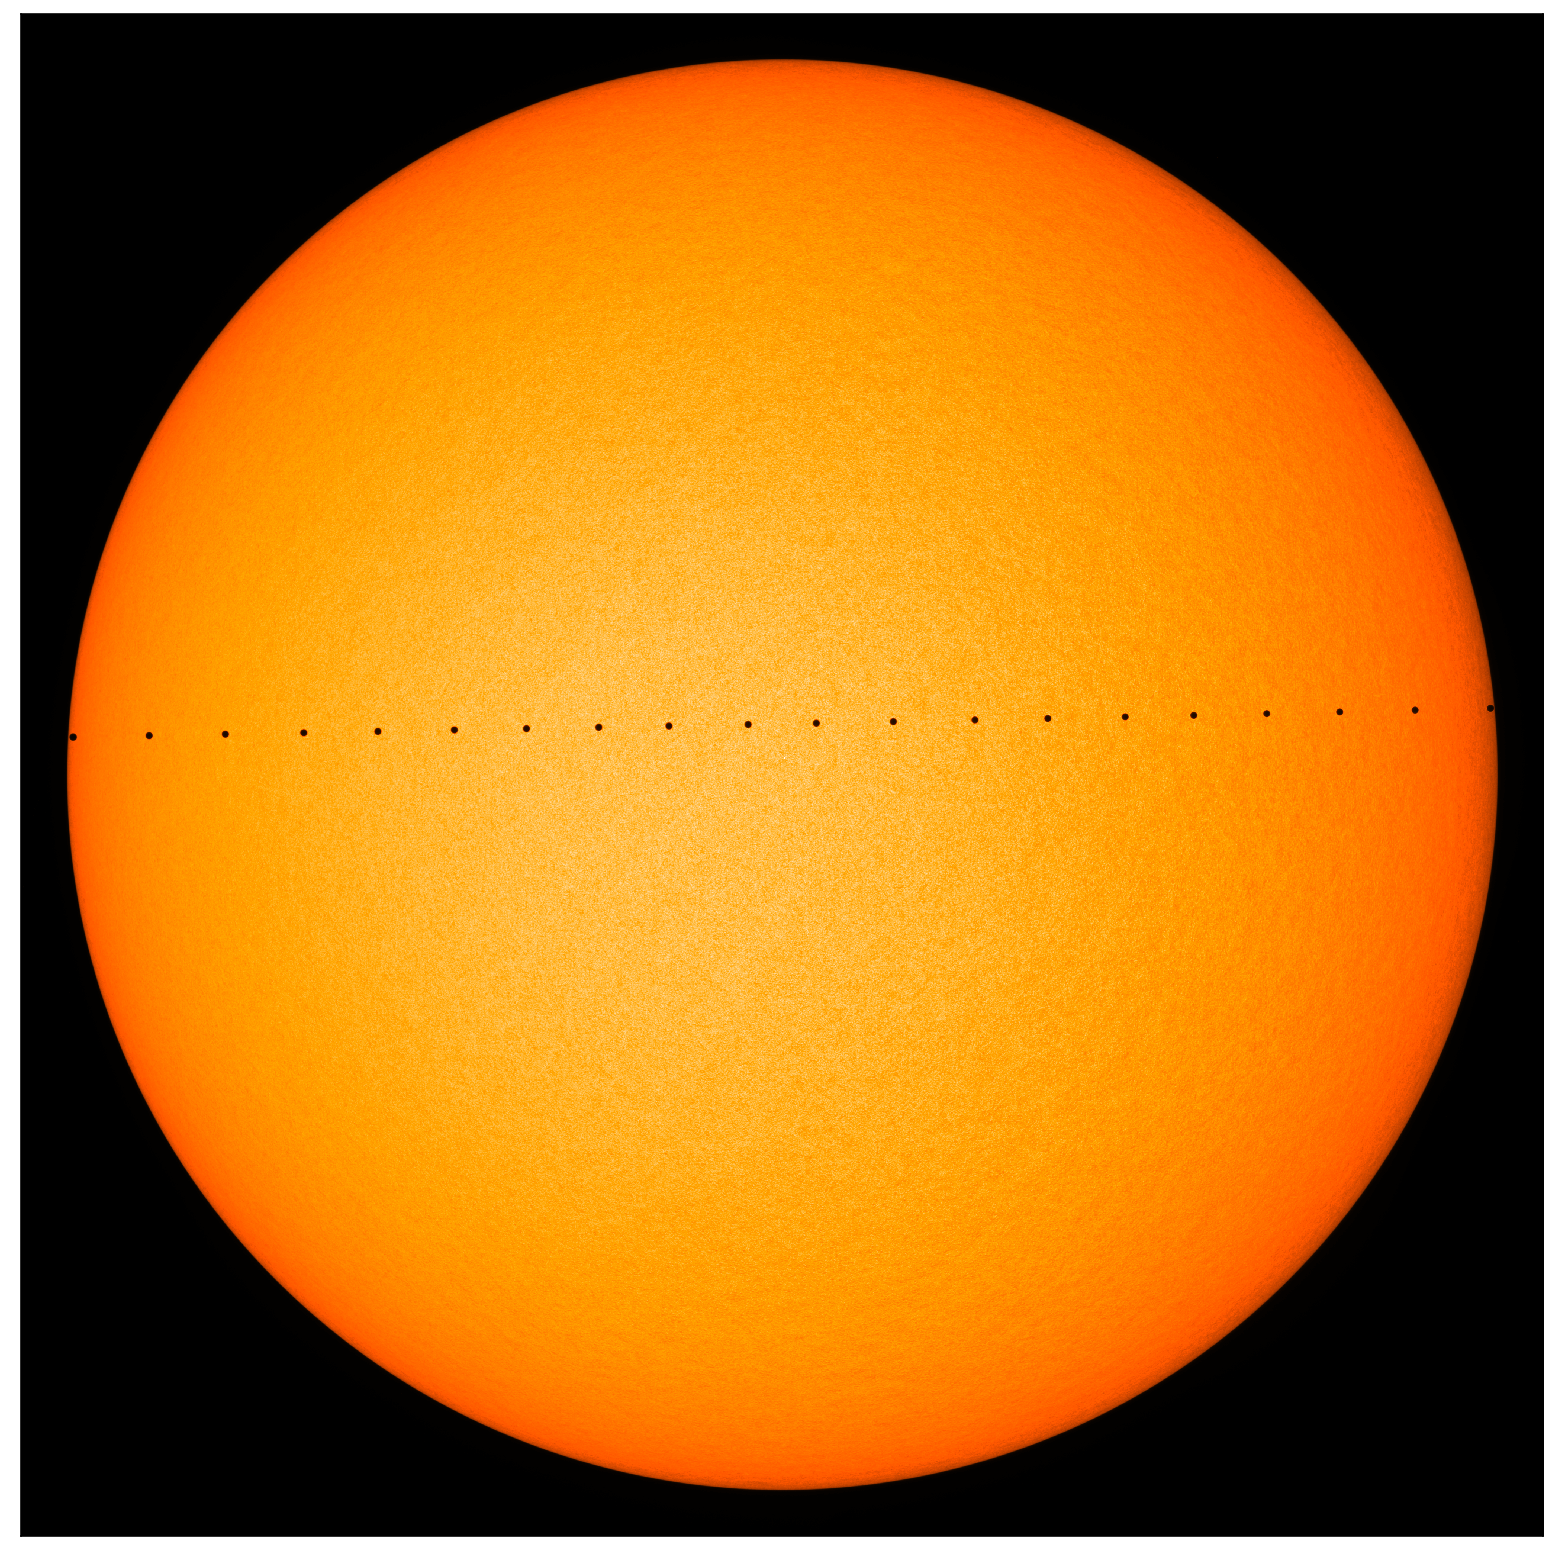

In [8]:
final = composite + masked_image
print("The maximum value of this array is ",(np.nanmax(final)))
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(final,cmap='ds9heat',vmax=62702.0,vmin=0,origin='lower') # Use the maximum value from 2016

In [9]:
print(np.nanmax(final),np.nanmin(final))

961863.0 -2147483648.0


Finally, save the figure at its native resolution (4096x4096 pixels):

In [10]:
%%capture
# dpi for retina display
# detect monitor dpi automatically here: http://www.infobyip.com/detectmonitordpi.php
my_dpi=192
fig = plt.figure(figsize=(4096.0/my_dpi, 4096.0/my_dpi), dpi=my_dpi)
ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(final,cmap='ds9heat',vmax=62702.0,vmin=0,origin='lower',interpolation='nearest')
fig.savefig('mercury_composite_HMI_2019.jpg')